In [1]:
# python imports
import pip
try:
    __import__("h5py")
except ImportError:
    pip.main(['install', "h5py"])  
import h5py
import numpy as np
import ROOT
import json
import sys
import uproot

# custom scripts
from utils.histograms import extended_hist
import utils.rootformatting as rf
rf.atlasstyle()

# root settings
palette=(70,0,1)           
ROOT.gStyle.SetPalette(palette[0],palette[1],palette[2])
ROOT.gStyle.SetGridStyle(1)
ROOT.gStyle.SetGridWidth(1)

def makeHist(name, binValues, binValuesStatErrs, binLow, binWidth):
    h = ROOT.TH1D(name, "", len(binValues), binLow, float(len(binValues))*binWidth+binLow)
    for (iBin, val) in enumerate(binValues):
        h.SetBinContent(iBin+1, val)
        h.SetBinError(iBin+1, binValuesStatErrs[iBin])
    return h

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Collecting h5py

Using cached h5py-3.11.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.5 kB)

Requirement already satisfied: numpy>=1.17.3 in /venv/lib/python3.9/site-packages (from h5py) (1.24.4)

Using cached h5py-3.11.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.3 MB)

Installing collected packages: h5py

Successfully installed h5py-3.11.0

Welcome to JupyROOT 6.28/12


In [3]:
# settings
samples = {
	"data" : ["Data", ROOT.kBlack], # black
	"ttbar" : ["t#bar{t}", ROOT.kRed], # red
	"Wt" : ["tW", ROOT.kOrange],
	"WW" : ["WW", ROOT.kGreen],
	"Zee" : ["Z#rightarrowee", ROOT.kBlue+1],
	"Zmumu": ["Z#rightarrow#mu#mu", ROOT.kBlue+2],
	"Ztautau": ["Z#rightarrow#tau#tau", ROOT.kBlue],
	"fake" : ["Fake lepton", ROOT.kViolet]
}
norm = True

In [15]:
# load data
inFileName = "/home/abadea/analysis/ttbarPbPb/AnalysisTop/run/TRExFitter/input/PbPbv30/hists.root"
f = uproot.open(inFileName)

# bin settings
limits = [0,330]
binWidth = 15
nbins = int((limits[1]-limits[0])/binWidth)
bins = np.linspace(limits[0],limits[1],nbins+1)
binLow = bins[0]
binCenters = (bins + binWidth/2)[:-1]

# histogram
trees = [i for i in f.keys() if "nominal" in i and "emu" in i]
regions = ["CR", "SR"]
H = {} # histograms
I = {} # integrals

# populate
for region in regions:
    H[region] = {}
    I[region] = {}

# histogram
for t in trees:
    
    # load
    sample = t.split("-nominal")[0].split("emu-")[1]
    label, color = samples[sample]
    mll = np.array(f[t]['mll'].array()).flatten()
    w = np.array(f[t]['weight'].array()).flatten()
    # cuts
    llpt = np.array(f[t]['llpt'].array())

    # CR and SR
    for region in regions:
        
        # cuts
        cut = (llpt > 40) if region == "SR" else (llpt <= 40)
        
        # histogram and normalize
        binValues, binValuesStatErrs, bin_centers, bin_edges = extended_hist(x=mll[cut], nbins=nbins, limits=limits, underflow=False, overflow=False, weights=w[cut])
        H[region][sample] = makeHist(f"h_{region}_{sample}", binValues, binValuesStatErrs, binLow, binWidth)
        I[region][sample] = H[region][sample].Integral()
        if norm: 
            print(region, sample, H[region][sample].Integral())
            try:
                H[region][sample].Scale(1./H[region][sample].Integral())
            except:
                continue

CR data 17.0
SR data 25.0
CR ttbar 3.5144651578068338
SR ttbar 12.96404674739396
CR Wt 0.2049542232045246
SR Wt 0.7720165433904068
CR WW 1.0661345294666147
SR WW 1.3718877507525298
CR Zee 0.0
SR Zee 0.0
CR Zmumu 0.0
SR Zmumu 0.0
CR Ztautau 4.806710741539668
SR Ztautau 0.6873591694069038
CR fake 8.742319014478774
SR fake 3.3624303901841177


Warning in <TROOT::Append>: Replacing existing TH1: h_SR_fake (Potential memory leak).


Zee 0.0
Zmumu 0.0
Zee 0.0
Zmumu 0.0


Info in <TCanvas::Print>: pdf file mll_CR_15GeV.pdf has been created
Info in <TCanvas::Print>: pdf file mll_SR_15GeV.pdf has been created


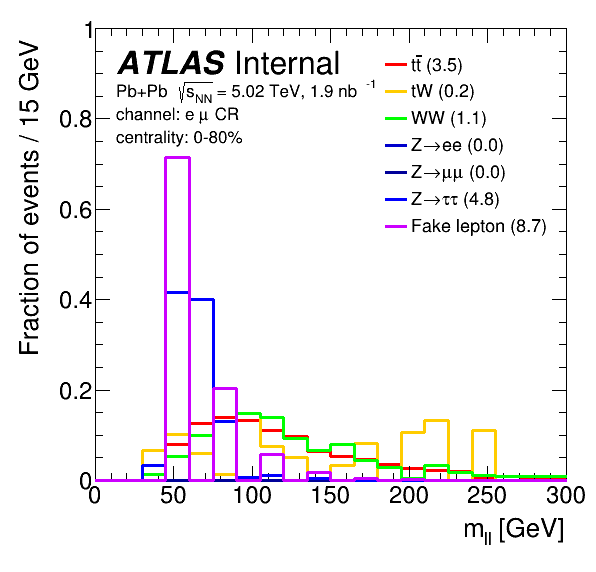

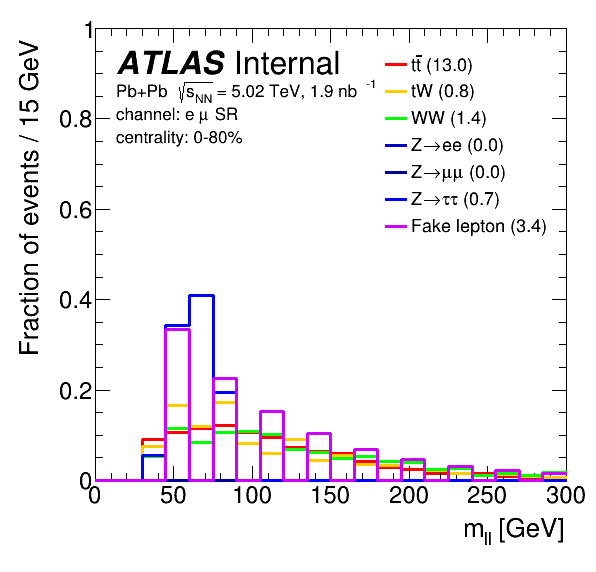

In [16]:
# hist style
style1d = { 
    "title": "",
    "x_title_offset": 1.1,
    "x_label_size": 0.045,
    "y_title_offset": 1.4,
    "y_label_size": 0.045,
    "title_font": 42,
    "label_font": 42,
    "fill_color": 0,
    "x_title":"m_{ll} [GeV]",
    "y_title":f"Fraction of events / {binWidth} GeV",
    "y_n_divisions" : 808,
    "x_n_divisions" : 808,
}
ROOT.gStyle.SetGridStyle(2)
ROOT.gStyle.SetGridWidth(1)
binString = f"{binWidth}GeV"

c = {}
leg = {}

for region in regions:

    c[region] = ROOT.TCanvas(f"c_{region}","",0,0,600,600)
    
    # legend
    l, lw = 0.64, 0.2 # left, left + width
    t, tw = 0.91, 0.33 # top, top - width
    leg[region] = ROOT.TLegend(l, t-tw, l+lw, t)
    leg[region].SetBorderSize(0)
    leg[region].SetFillColor(0)
    leg[region].SetFillStyle(0)
    leg[region].SetTextFont(42)
    leg[region].SetTextSize(0.035)
    
    # histograms
    for sample, h in H[region].items():
        label, color = samples[sample]
        if h.Integral() == 0:
            print(sample, h.Integral())
            # continue
        rf.format_hist(h, **style1d)
        h.GetYaxis().SetRangeUser(0,1.0)
        h.GetXaxis().SetRangeUser(0,300)
        h.SetLineColor(color)
        h.SetLineWidth(3)
        h.GetXaxis().CenterTitle(False)
        h.GetYaxis().CenterTitle(False)
        if sample == "data":
            continue # was asked to not include data
            h.Draw("E1")
            leg[region].AddEntry(h, f"{label} ({I[region][sample]:.1f})", "pe")
        else:
            h.Draw("hist same")
            leg[region].AddEntry(h, f"{label} ({I[region][sample]:.1f})", "l")
        
    # draw label
    left, top, wd, fs = 0.195, 0.87, 0.04, 0.03 # 0.2
    stamps = [
        rf.myText(left, top, 1, "#it{#bf{ATLAS}} Internal", 0.06),
        rf.myText(left, top-1*wd, 1, "Pb+Pb #sqrt{s_{NN}} = 5.02 TeV, 1.9 nb^{-1}", 0.033),
        rf.myText(left, top-2*wd, 1, f"channel: e#mu {region}", 0.033), # SR, Pre-Fit, 
        rf.myText(left, top-3*wd, 1, "centrality: 0-80%", 0.033),
        # rf.myText(left, top-4*wd, 1, "p_{T}^{ll} > 40 GeV,  n_{jets} #geq 2", 0.035),
        # rf.myText(left+0.1, top-3*wd, 1, "#geq 2 jets", 0.04),
    ]
    for stamp in stamps:
        stamp.Draw()
    
    leg[region].Draw()
    
    c[region].SaveAs(f"mll_{region}_{binString}.pdf")
    c[region].Draw()